## 라이브러리 불러오기

In [1]:
import os ; os.chdir("C:/Users/user/UNet-project")
import numpy as np
from netCDF4 import Dataset

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns

from torchvision import transforms, datasets

import matplotlib.pyplot as plt

# In[]
lr = 1e-3
batch_size = 4
num_epoch = 200
ckpt_dir = './checkpoint'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 네트워크 구축하기

### class 정의하기

- 신경망 모델을 nn.Module의 하위클래스로 정의하고, __init__에서 신경망 계층들을 초기화함.

- nn.Module을 상속받은 모든 클래스는 forward 메소드에 입력데이터에 대한 연산들을 구현함.

In [2]:
class UNet(nn.Module): 
    def __init__(self):
        super(UNet, self).__init__()
        
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]
            
            cbr = nn.Sequential(*layers)
            
            return cbr
        
        # Contracting path
        self.enc1_1 = CBR2d(in_channels=4, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        
        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)
        
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        
        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)
        
        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)
        
        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)
        
        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)
        
        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)
    
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
    
    # 각각의 레이어 연결하기    
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        
        pool1 = self.pool1(enc1_2)
        
        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2= self.pool2(enc2_2)
        
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3= self.pool3(enc3_2)
        
        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4= self.pool4(enc4_2)
        
        enc5_1 = self.enc5_1(pool4)
        
        dec5_1 = self.dec5_1(enc5_1)
        
        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)
        
        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)
        
        unpool2 = self.unpool2(dec3_1)
        
        cat2 = torch.cat((unpool2, enc2_2), dim=1) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec2_2 = self.dec2_2(cat2)
        
        dec2_1 = self.dec2_1(dec2_2)
        
        unpool1 = self.unpool1(dec2_1)
        
        cat1 = torch.cat((unpool1, enc1_2), dim=1) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)
        
        x = self.fc(dec1_1)
        
        return x
    

## 학습데이터 세팅

In [3]:
nc.variables

NameError: name 'nc' is not defined

In [4]:
# In[] SMOKE-CMAQ
# CMAQ 연평균 PM농도
pm2_5 = np.array([])

for i in range(1,120):
    a = 'ACONC.' + str(i)
    nc = Dataset(a, 'r')
    pm2_5 = np.append(pm2_5, np.array([[[nc.variables['PM2_5']]]]))
    
pm2_5 = np.reshape(pm2_5, [119,82,67])
pm2_5 = pm2_5[:,8:-10,2:-1]
pm2_5 = np.reshape(pm2_5, [119,64,64]) # convolution 연산을 위해

pm = pm2_5


y1 = np.array([])
y2 = np.array([])
y3 = np.array([])
y4 = np.array([])
y5 = np.array([])
y6 = np.array([])

for i in range(1,120):
    a = 'EMIS_AVG.' + str(i)
    nc = Dataset(a, 'r')
    y1 = np.append(y1, np.array([[[nc.variables['SO2']]]]))
    y2 = np.append(y2, np.array([[[nc.variables['PM2_5']]]]))
    y3 = np.append(y3, np.array([[[nc.variables['NOx']]]]))
    y4 = np.append(y4, np.array([[[nc.variables['VOCs']]]]))
    y5 = np.append(y5, np.array([[[nc.variables['NH3']]]]))
    y6 = np.append(y6, np.array([[[nc.variables['CO']]]]))
    
y1 = np.reshape(y1, [119,82,67])
y1 = y1[:,8:-10,2:-1]
y1 = np.reshape(y1, [119,64,64])
y1_max = np.max(y1)
y1_min = np.min(y1)

y2 = np.reshape(y2, [119,82,67])
y2 = y2[:,8:-10,2:-1]
y2 = np.reshape(y2, [119,64,64])
y2_max = np.max(y2)
y2_min = np.min(y2)

y3 = np.reshape(y3, [119,82,67])
y3 = y3[:,8:-10,2:-1]
y3 = np.reshape(y3, [119,64,64])
y3_max = np.max(y3)
y3_min = np.min(y3)

y4 = np.reshape(y4, [119,82,67])
y4 = y4[:,8:-10,2:-1]
y4 = np.reshape(y4, [119,64,64])
y4_max = np.max(y4)
y4_min = np.min(y4)

y5 = np.reshape(y5, [119,82,67])
y5 = y5[:,8:-10,2:-1]
y5 = np.reshape(y5, [119,64,64])
y5_max = np.max(y5)
y5_min = np.min(y5)
    
y6 = np.reshape(y6, [119,82,67])
y6 = y6[:,8:-10,2:-1]
y6 = np.reshape(y6, [119,64,64])


def pm_data():
    a = np.concatenate((y3,y1,y4,y5), axis=0) # PM2.5, SO2, NH3
    a = np.reshape(a,[4,119,64,64]) # data generation for CNN ??
    a = np.transpose(a, (1,2,3,0)) # CNN 학습을 위한 순서변경
    print(np.shape(a))
    
    y = pm
    
    y = np.reshape(y, [119,64,64,1]) # CNN output data
    x_train = a[0:70]
    y_train = y[0:70]
    x_test = a[70:]
    pm2_5 = y[70:]
    return x_train, y_train, x_test, pm2_5, a, y


pm_data1 = pm_data()
x_train, y_train, x_test, pm2_5, a, y = pm_data1[0], pm_data1[1], pm_data1[2], pm_data1[3], pm_data1[4], pm_data1[5]#, pm_data1[6], pm_data1[7] 

# In[]

class TensorData(torch.utils.data.Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.x_data = self.x_data.permute(0,3,1,2) # 이미지 개수, 채널 수, 너비, 높이
        self.y_data = self.y_data.permute(0,3,1,2)
        self.len = self.y_data.shape[0]
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len

# 인스턴스(데이터) 생성
train_data = TensorData(x_train, y_train)

# 만들어진 데이터를 배치형태로 만들어주기위해 DataLoader에다가 넣어줌
train_loader = DataLoader(train_data, batch_size = 10, shuffle=True)

# In[] 데이터의 사이즈와 실제 데이터 확인해보기
train_data[0][0].size()



(119, 64, 64, 4)


torch.Size([4, 64, 64])

In [5]:
print(x_train.shape, torch.FloatTensor(x_train).permute(0,3,1,2).shape)

(70, 64, 64, 4) torch.Size([70, 4, 64, 64])


In [6]:
# In[] train_loader안의 실제값 한개 뽑아서 확인
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [7]:
print(images.shape, labels.shape)

torch.Size([10, 4, 64, 64]) torch.Size([10, 1, 64, 64])


In [8]:
# In[] 네트워크 생성하기
net = UNet().to(device)

# 손실함수 정의하기
fn_loss = nn.MSELoss().to(device)

# Optimizer 설정하기
optim = torch.optim.Adam(net.parameters(), lr=lr)

# 그밖의 부수적인 variables 설정하기
num_data_train = len(x_train)

num_batch_train = np.ceil(num_data_train / batch_size)

# In[] 네트워크 저장하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
        
    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               "./%s/model_epoch%d.pth" % (ckpt_dir, epoch))

# In[] 네트워크 불러오기
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch
    
    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    
    dict_model = torch.load('./%s/%s' % (ckpt_dir, ckpt_lst[-1]))
    
    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('pth')[0])
    
    return net, optim, epoch

## 모델 학습하기

In [96]:
# In[] 네트워크 학습시키기

st_epoch = 0
#net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

import time
start = time.time()

for epoch in range(st_epoch + 1, num_epoch + 1):
    net.train()
    loss_arr = []
    
    for batch, data in enumerate(train_loader, 1):
        # forward pass
        label = data[1].to(device)
        input = data[0].to(device)
        
        output = net(input)
        
        # backward pass
        optim.zero_grad()
        
        loss = fn_loss(output, label)
        loss.backward()
        
        optim.step()
        
        # 손실함수 계산
        loss_arr += [loss.item()]
        
        print('TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f' %
              (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))
    
    if epoch % 50 == 0:
        save(ckpt_dir = ckpt_dir, net=net, optim=optim, epoch=epoch)
        

print("time :", time.time() - start)

TRAIN: EPOCH 0001 / 0200 | BATCH 0001 / 0018 | LOSS 0.0076
TRAIN: EPOCH 0001 / 0200 | BATCH 0002 / 0018 | LOSS 0.0096
TRAIN: EPOCH 0001 / 0200 | BATCH 0003 / 0018 | LOSS 0.0120
TRAIN: EPOCH 0001 / 0200 | BATCH 0004 / 0018 | LOSS 0.0106
TRAIN: EPOCH 0001 / 0200 | BATCH 0005 / 0018 | LOSS 0.0107
TRAIN: EPOCH 0001 / 0200 | BATCH 0006 / 0018 | LOSS 0.0102
TRAIN: EPOCH 0001 / 0200 | BATCH 0007 / 0018 | LOSS 0.0102
TRAIN: EPOCH 0002 / 0200 | BATCH 0001 / 0018 | LOSS 0.0127
TRAIN: EPOCH 0002 / 0200 | BATCH 0002 / 0018 | LOSS 0.0120
TRAIN: EPOCH 0002 / 0200 | BATCH 0003 / 0018 | LOSS 0.0110
TRAIN: EPOCH 0002 / 0200 | BATCH 0004 / 0018 | LOSS 0.0104
TRAIN: EPOCH 0002 / 0200 | BATCH 0005 / 0018 | LOSS 0.0102
TRAIN: EPOCH 0002 / 0200 | BATCH 0006 / 0018 | LOSS 0.0101
TRAIN: EPOCH 0002 / 0200 | BATCH 0007 / 0018 | LOSS 0.0106
TRAIN: EPOCH 0003 / 0200 | BATCH 0001 / 0018 | LOSS 0.0067
TRAIN: EPOCH 0003 / 0200 | BATCH 0002 / 0018 | LOSS 0.0071
TRAIN: EPOCH 0003 / 0200 | BATCH 0003 / 0018 | LOSS 0.00

TRAIN: EPOCH 0021 / 0200 | BATCH 0004 / 0018 | LOSS 0.0073
TRAIN: EPOCH 0021 / 0200 | BATCH 0005 / 0018 | LOSS 0.0085
TRAIN: EPOCH 0021 / 0200 | BATCH 0006 / 0018 | LOSS 0.0091
TRAIN: EPOCH 0021 / 0200 | BATCH 0007 / 0018 | LOSS 0.0088
TRAIN: EPOCH 0022 / 0200 | BATCH 0001 / 0018 | LOSS 0.0076
TRAIN: EPOCH 0022 / 0200 | BATCH 0002 / 0018 | LOSS 0.0084
TRAIN: EPOCH 0022 / 0200 | BATCH 0003 / 0018 | LOSS 0.0081
TRAIN: EPOCH 0022 / 0200 | BATCH 0004 / 0018 | LOSS 0.0085
TRAIN: EPOCH 0022 / 0200 | BATCH 0005 / 0018 | LOSS 0.0083
TRAIN: EPOCH 0022 / 0200 | BATCH 0006 / 0018 | LOSS 0.0082
TRAIN: EPOCH 0022 / 0200 | BATCH 0007 / 0018 | LOSS 0.0082
TRAIN: EPOCH 0023 / 0200 | BATCH 0001 / 0018 | LOSS 0.0093
TRAIN: EPOCH 0023 / 0200 | BATCH 0002 / 0018 | LOSS 0.0132
TRAIN: EPOCH 0023 / 0200 | BATCH 0003 / 0018 | LOSS 0.0116
TRAIN: EPOCH 0023 / 0200 | BATCH 0004 / 0018 | LOSS 0.0105
TRAIN: EPOCH 0023 / 0200 | BATCH 0005 / 0018 | LOSS 0.0101
TRAIN: EPOCH 0023 / 0200 | BATCH 0006 / 0018 | LOSS 0.01

TRAIN: EPOCH 0041 / 0200 | BATCH 0007 / 0018 | LOSS 0.0124
TRAIN: EPOCH 0042 / 0200 | BATCH 0001 / 0018 | LOSS 0.0161
TRAIN: EPOCH 0042 / 0200 | BATCH 0002 / 0018 | LOSS 0.0165
TRAIN: EPOCH 0042 / 0200 | BATCH 0003 / 0018 | LOSS 0.0146
TRAIN: EPOCH 0042 / 0200 | BATCH 0004 / 0018 | LOSS 0.0136
TRAIN: EPOCH 0042 / 0200 | BATCH 0005 / 0018 | LOSS 0.0142
TRAIN: EPOCH 0042 / 0200 | BATCH 0006 / 0018 | LOSS 0.0142
TRAIN: EPOCH 0042 / 0200 | BATCH 0007 / 0018 | LOSS 0.0146
TRAIN: EPOCH 0043 / 0200 | BATCH 0001 / 0018 | LOSS 0.0113
TRAIN: EPOCH 0043 / 0200 | BATCH 0002 / 0018 | LOSS 0.0113
TRAIN: EPOCH 0043 / 0200 | BATCH 0003 / 0018 | LOSS 0.0094
TRAIN: EPOCH 0043 / 0200 | BATCH 0004 / 0018 | LOSS 0.0092
TRAIN: EPOCH 0043 / 0200 | BATCH 0005 / 0018 | LOSS 0.0090
TRAIN: EPOCH 0043 / 0200 | BATCH 0006 / 0018 | LOSS 0.0112
TRAIN: EPOCH 0043 / 0200 | BATCH 0007 / 0018 | LOSS 0.0110
TRAIN: EPOCH 0044 / 0200 | BATCH 0001 / 0018 | LOSS 0.0071
TRAIN: EPOCH 0044 / 0200 | BATCH 0002 / 0018 | LOSS 0.00

TRAIN: EPOCH 0062 / 0200 | BATCH 0004 / 0018 | LOSS 0.0120
TRAIN: EPOCH 0062 / 0200 | BATCH 0005 / 0018 | LOSS 0.0108
TRAIN: EPOCH 0062 / 0200 | BATCH 0006 / 0018 | LOSS 0.0147
TRAIN: EPOCH 0062 / 0200 | BATCH 0007 / 0018 | LOSS 0.0155
TRAIN: EPOCH 0063 / 0200 | BATCH 0001 / 0018 | LOSS 0.0067
TRAIN: EPOCH 0063 / 0200 | BATCH 0002 / 0018 | LOSS 0.0135
TRAIN: EPOCH 0063 / 0200 | BATCH 0003 / 0018 | LOSS 0.0110
TRAIN: EPOCH 0063 / 0200 | BATCH 0004 / 0018 | LOSS 0.0137
TRAIN: EPOCH 0063 / 0200 | BATCH 0005 / 0018 | LOSS 0.0127
TRAIN: EPOCH 0063 / 0200 | BATCH 0006 / 0018 | LOSS 0.0127
TRAIN: EPOCH 0063 / 0200 | BATCH 0007 / 0018 | LOSS 0.0134
TRAIN: EPOCH 0064 / 0200 | BATCH 0001 / 0018 | LOSS 0.0161
TRAIN: EPOCH 0064 / 0200 | BATCH 0002 / 0018 | LOSS 0.0254
TRAIN: EPOCH 0064 / 0200 | BATCH 0003 / 0018 | LOSS 0.0194
TRAIN: EPOCH 0064 / 0200 | BATCH 0004 / 0018 | LOSS 0.0180
TRAIN: EPOCH 0064 / 0200 | BATCH 0005 / 0018 | LOSS 0.0176
TRAIN: EPOCH 0064 / 0200 | BATCH 0006 / 0018 | LOSS 0.01

TRAIN: EPOCH 0082 / 0200 | BATCH 0006 / 0018 | LOSS 0.0127
TRAIN: EPOCH 0082 / 0200 | BATCH 0007 / 0018 | LOSS 0.0119
TRAIN: EPOCH 0083 / 0200 | BATCH 0001 / 0018 | LOSS 0.0067
TRAIN: EPOCH 0083 / 0200 | BATCH 0002 / 0018 | LOSS 0.0084
TRAIN: EPOCH 0083 / 0200 | BATCH 0003 / 0018 | LOSS 0.0083
TRAIN: EPOCH 0083 / 0200 | BATCH 0004 / 0018 | LOSS 0.0104
TRAIN: EPOCH 0083 / 0200 | BATCH 0005 / 0018 | LOSS 0.0106
TRAIN: EPOCH 0083 / 0200 | BATCH 0006 / 0018 | LOSS 0.0109
TRAIN: EPOCH 0083 / 0200 | BATCH 0007 / 0018 | LOSS 0.0109
TRAIN: EPOCH 0084 / 0200 | BATCH 0001 / 0018 | LOSS 0.0067
TRAIN: EPOCH 0084 / 0200 | BATCH 0002 / 0018 | LOSS 0.0086
TRAIN: EPOCH 0084 / 0200 | BATCH 0003 / 0018 | LOSS 0.0083
TRAIN: EPOCH 0084 / 0200 | BATCH 0004 / 0018 | LOSS 0.0077
TRAIN: EPOCH 0084 / 0200 | BATCH 0005 / 0018 | LOSS 0.0091
TRAIN: EPOCH 0084 / 0200 | BATCH 0006 / 0018 | LOSS 0.0094
TRAIN: EPOCH 0084 / 0200 | BATCH 0007 / 0018 | LOSS 0.0090
TRAIN: EPOCH 0085 / 0200 | BATCH 0001 / 0018 | LOSS 0.00

TRAIN: EPOCH 0103 / 0200 | BATCH 0003 / 0018 | LOSS 0.0097
TRAIN: EPOCH 0103 / 0200 | BATCH 0004 / 0018 | LOSS 0.0096
TRAIN: EPOCH 0103 / 0200 | BATCH 0005 / 0018 | LOSS 0.0105
TRAIN: EPOCH 0103 / 0200 | BATCH 0006 / 0018 | LOSS 0.0102
TRAIN: EPOCH 0103 / 0200 | BATCH 0007 / 0018 | LOSS 0.0104
TRAIN: EPOCH 0104 / 0200 | BATCH 0001 / 0018 | LOSS 0.0098
TRAIN: EPOCH 0104 / 0200 | BATCH 0002 / 0018 | LOSS 0.0158
TRAIN: EPOCH 0104 / 0200 | BATCH 0003 / 0018 | LOSS 0.0168
TRAIN: EPOCH 0104 / 0200 | BATCH 0004 / 0018 | LOSS 0.0150
TRAIN: EPOCH 0104 / 0200 | BATCH 0005 / 0018 | LOSS 0.0156
TRAIN: EPOCH 0104 / 0200 | BATCH 0006 / 0018 | LOSS 0.0147
TRAIN: EPOCH 0104 / 0200 | BATCH 0007 / 0018 | LOSS 0.0142
TRAIN: EPOCH 0105 / 0200 | BATCH 0001 / 0018 | LOSS 0.0170
TRAIN: EPOCH 0105 / 0200 | BATCH 0002 / 0018 | LOSS 0.0148
TRAIN: EPOCH 0105 / 0200 | BATCH 0003 / 0018 | LOSS 0.0127
TRAIN: EPOCH 0105 / 0200 | BATCH 0004 / 0018 | LOSS 0.0126
TRAIN: EPOCH 0105 / 0200 | BATCH 0005 / 0018 | LOSS 0.01

TRAIN: EPOCH 0123 / 0200 | BATCH 0007 / 0018 | LOSS 0.0147
TRAIN: EPOCH 0124 / 0200 | BATCH 0001 / 0018 | LOSS 0.0158
TRAIN: EPOCH 0124 / 0200 | BATCH 0002 / 0018 | LOSS 0.0173
TRAIN: EPOCH 0124 / 0200 | BATCH 0003 / 0018 | LOSS 0.0140
TRAIN: EPOCH 0124 / 0200 | BATCH 0004 / 0018 | LOSS 0.0158
TRAIN: EPOCH 0124 / 0200 | BATCH 0005 / 0018 | LOSS 0.0139
TRAIN: EPOCH 0124 / 0200 | BATCH 0006 / 0018 | LOSS 0.0140
TRAIN: EPOCH 0124 / 0200 | BATCH 0007 / 0018 | LOSS 0.0135
TRAIN: EPOCH 0125 / 0200 | BATCH 0001 / 0018 | LOSS 0.0154
TRAIN: EPOCH 0125 / 0200 | BATCH 0002 / 0018 | LOSS 0.0116
TRAIN: EPOCH 0125 / 0200 | BATCH 0003 / 0018 | LOSS 0.0106
TRAIN: EPOCH 0125 / 0200 | BATCH 0004 / 0018 | LOSS 0.0113
TRAIN: EPOCH 0125 / 0200 | BATCH 0005 / 0018 | LOSS 0.0108
TRAIN: EPOCH 0125 / 0200 | BATCH 0006 / 0018 | LOSS 0.0122
TRAIN: EPOCH 0125 / 0200 | BATCH 0007 / 0018 | LOSS 0.0114
TRAIN: EPOCH 0126 / 0200 | BATCH 0001 / 0018 | LOSS 0.0109
TRAIN: EPOCH 0126 / 0200 | BATCH 0002 / 0018 | LOSS 0.00

TRAIN: EPOCH 0144 / 0200 | BATCH 0005 / 0018 | LOSS 0.0093
TRAIN: EPOCH 0144 / 0200 | BATCH 0006 / 0018 | LOSS 0.0093
TRAIN: EPOCH 0144 / 0200 | BATCH 0007 / 0018 | LOSS 0.0094
TRAIN: EPOCH 0145 / 0200 | BATCH 0001 / 0018 | LOSS 0.0086
TRAIN: EPOCH 0145 / 0200 | BATCH 0002 / 0018 | LOSS 0.0099
TRAIN: EPOCH 0145 / 0200 | BATCH 0003 / 0018 | LOSS 0.0094
TRAIN: EPOCH 0145 / 0200 | BATCH 0004 / 0018 | LOSS 0.0101
TRAIN: EPOCH 0145 / 0200 | BATCH 0005 / 0018 | LOSS 0.0118
TRAIN: EPOCH 0145 / 0200 | BATCH 0006 / 0018 | LOSS 0.0130
TRAIN: EPOCH 0145 / 0200 | BATCH 0007 / 0018 | LOSS 0.0124
TRAIN: EPOCH 0146 / 0200 | BATCH 0001 / 0018 | LOSS 0.0134
TRAIN: EPOCH 0146 / 0200 | BATCH 0002 / 0018 | LOSS 0.0105
TRAIN: EPOCH 0146 / 0200 | BATCH 0003 / 0018 | LOSS 0.0094
TRAIN: EPOCH 0146 / 0200 | BATCH 0004 / 0018 | LOSS 0.0111
TRAIN: EPOCH 0146 / 0200 | BATCH 0005 / 0018 | LOSS 0.0109
TRAIN: EPOCH 0146 / 0200 | BATCH 0006 / 0018 | LOSS 0.0110
TRAIN: EPOCH 0146 / 0200 | BATCH 0007 / 0018 | LOSS 0.01

TRAIN: EPOCH 0164 / 0200 | BATCH 0006 / 0018 | LOSS 0.0118
TRAIN: EPOCH 0164 / 0200 | BATCH 0007 / 0018 | LOSS 0.0116
TRAIN: EPOCH 0165 / 0200 | BATCH 0001 / 0018 | LOSS 0.0149
TRAIN: EPOCH 0165 / 0200 | BATCH 0002 / 0018 | LOSS 0.0097
TRAIN: EPOCH 0165 / 0200 | BATCH 0003 / 0018 | LOSS 0.0107
TRAIN: EPOCH 0165 / 0200 | BATCH 0004 / 0018 | LOSS 0.0108
TRAIN: EPOCH 0165 / 0200 | BATCH 0005 / 0018 | LOSS 0.0101
TRAIN: EPOCH 0165 / 0200 | BATCH 0006 / 0018 | LOSS 0.0108
TRAIN: EPOCH 0165 / 0200 | BATCH 0007 / 0018 | LOSS 0.0106
TRAIN: EPOCH 0166 / 0200 | BATCH 0001 / 0018 | LOSS 0.0071
TRAIN: EPOCH 0166 / 0200 | BATCH 0002 / 0018 | LOSS 0.0108
TRAIN: EPOCH 0166 / 0200 | BATCH 0003 / 0018 | LOSS 0.0092
TRAIN: EPOCH 0166 / 0200 | BATCH 0004 / 0018 | LOSS 0.0095
TRAIN: EPOCH 0166 / 0200 | BATCH 0005 / 0018 | LOSS 0.0101
TRAIN: EPOCH 0166 / 0200 | BATCH 0006 / 0018 | LOSS 0.0093
TRAIN: EPOCH 0166 / 0200 | BATCH 0007 / 0018 | LOSS 0.0102
TRAIN: EPOCH 0167 / 0200 | BATCH 0001 / 0018 | LOSS 0.00

TRAIN: EPOCH 0185 / 0200 | BATCH 0003 / 0018 | LOSS 0.0089
TRAIN: EPOCH 0185 / 0200 | BATCH 0004 / 0018 | LOSS 0.0084
TRAIN: EPOCH 0185 / 0200 | BATCH 0005 / 0018 | LOSS 0.0084
TRAIN: EPOCH 0185 / 0200 | BATCH 0006 / 0018 | LOSS 0.0078
TRAIN: EPOCH 0185 / 0200 | BATCH 0007 / 0018 | LOSS 0.0079
TRAIN: EPOCH 0186 / 0200 | BATCH 0001 / 0018 | LOSS 0.0051
TRAIN: EPOCH 0186 / 0200 | BATCH 0002 / 0018 | LOSS 0.0108
TRAIN: EPOCH 0186 / 0200 | BATCH 0003 / 0018 | LOSS 0.0097
TRAIN: EPOCH 0186 / 0200 | BATCH 0004 / 0018 | LOSS 0.0139
TRAIN: EPOCH 0186 / 0200 | BATCH 0005 / 0018 | LOSS 0.0130
TRAIN: EPOCH 0186 / 0200 | BATCH 0006 / 0018 | LOSS 0.0117
TRAIN: EPOCH 0186 / 0200 | BATCH 0007 / 0018 | LOSS 0.0113
TRAIN: EPOCH 0187 / 0200 | BATCH 0001 / 0018 | LOSS 0.0114
TRAIN: EPOCH 0187 / 0200 | BATCH 0002 / 0018 | LOSS 0.0112
TRAIN: EPOCH 0187 / 0200 | BATCH 0003 / 0018 | LOSS 0.0088
TRAIN: EPOCH 0187 / 0200 | BATCH 0004 / 0018 | LOSS 0.0084
TRAIN: EPOCH 0187 / 0200 | BATCH 0005 / 0018 | LOSS 0.00

## 결과확인

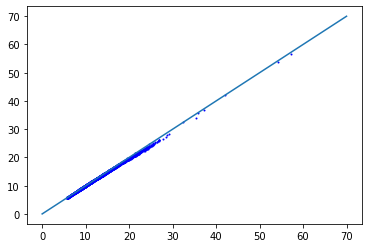

In [10]:
# 테스트데이터 1개 포인트
pre = net(torch.FloatTensor(x_test).permute(0,3,1,2).to(device))
pre = np.reshape(pre.cpu().detach().numpy(),(49,64,64))

tt = pm2_5.reshape(49,64,64)


# In[]
plt.plot(pre[0][::-1].reshape(64*64), pm2_5[0][::-1].reshape(64*64),'bo', markersize=1)
plt.plot([0,70],[0,70])

Text(0, 0.5, 'CMAQ')

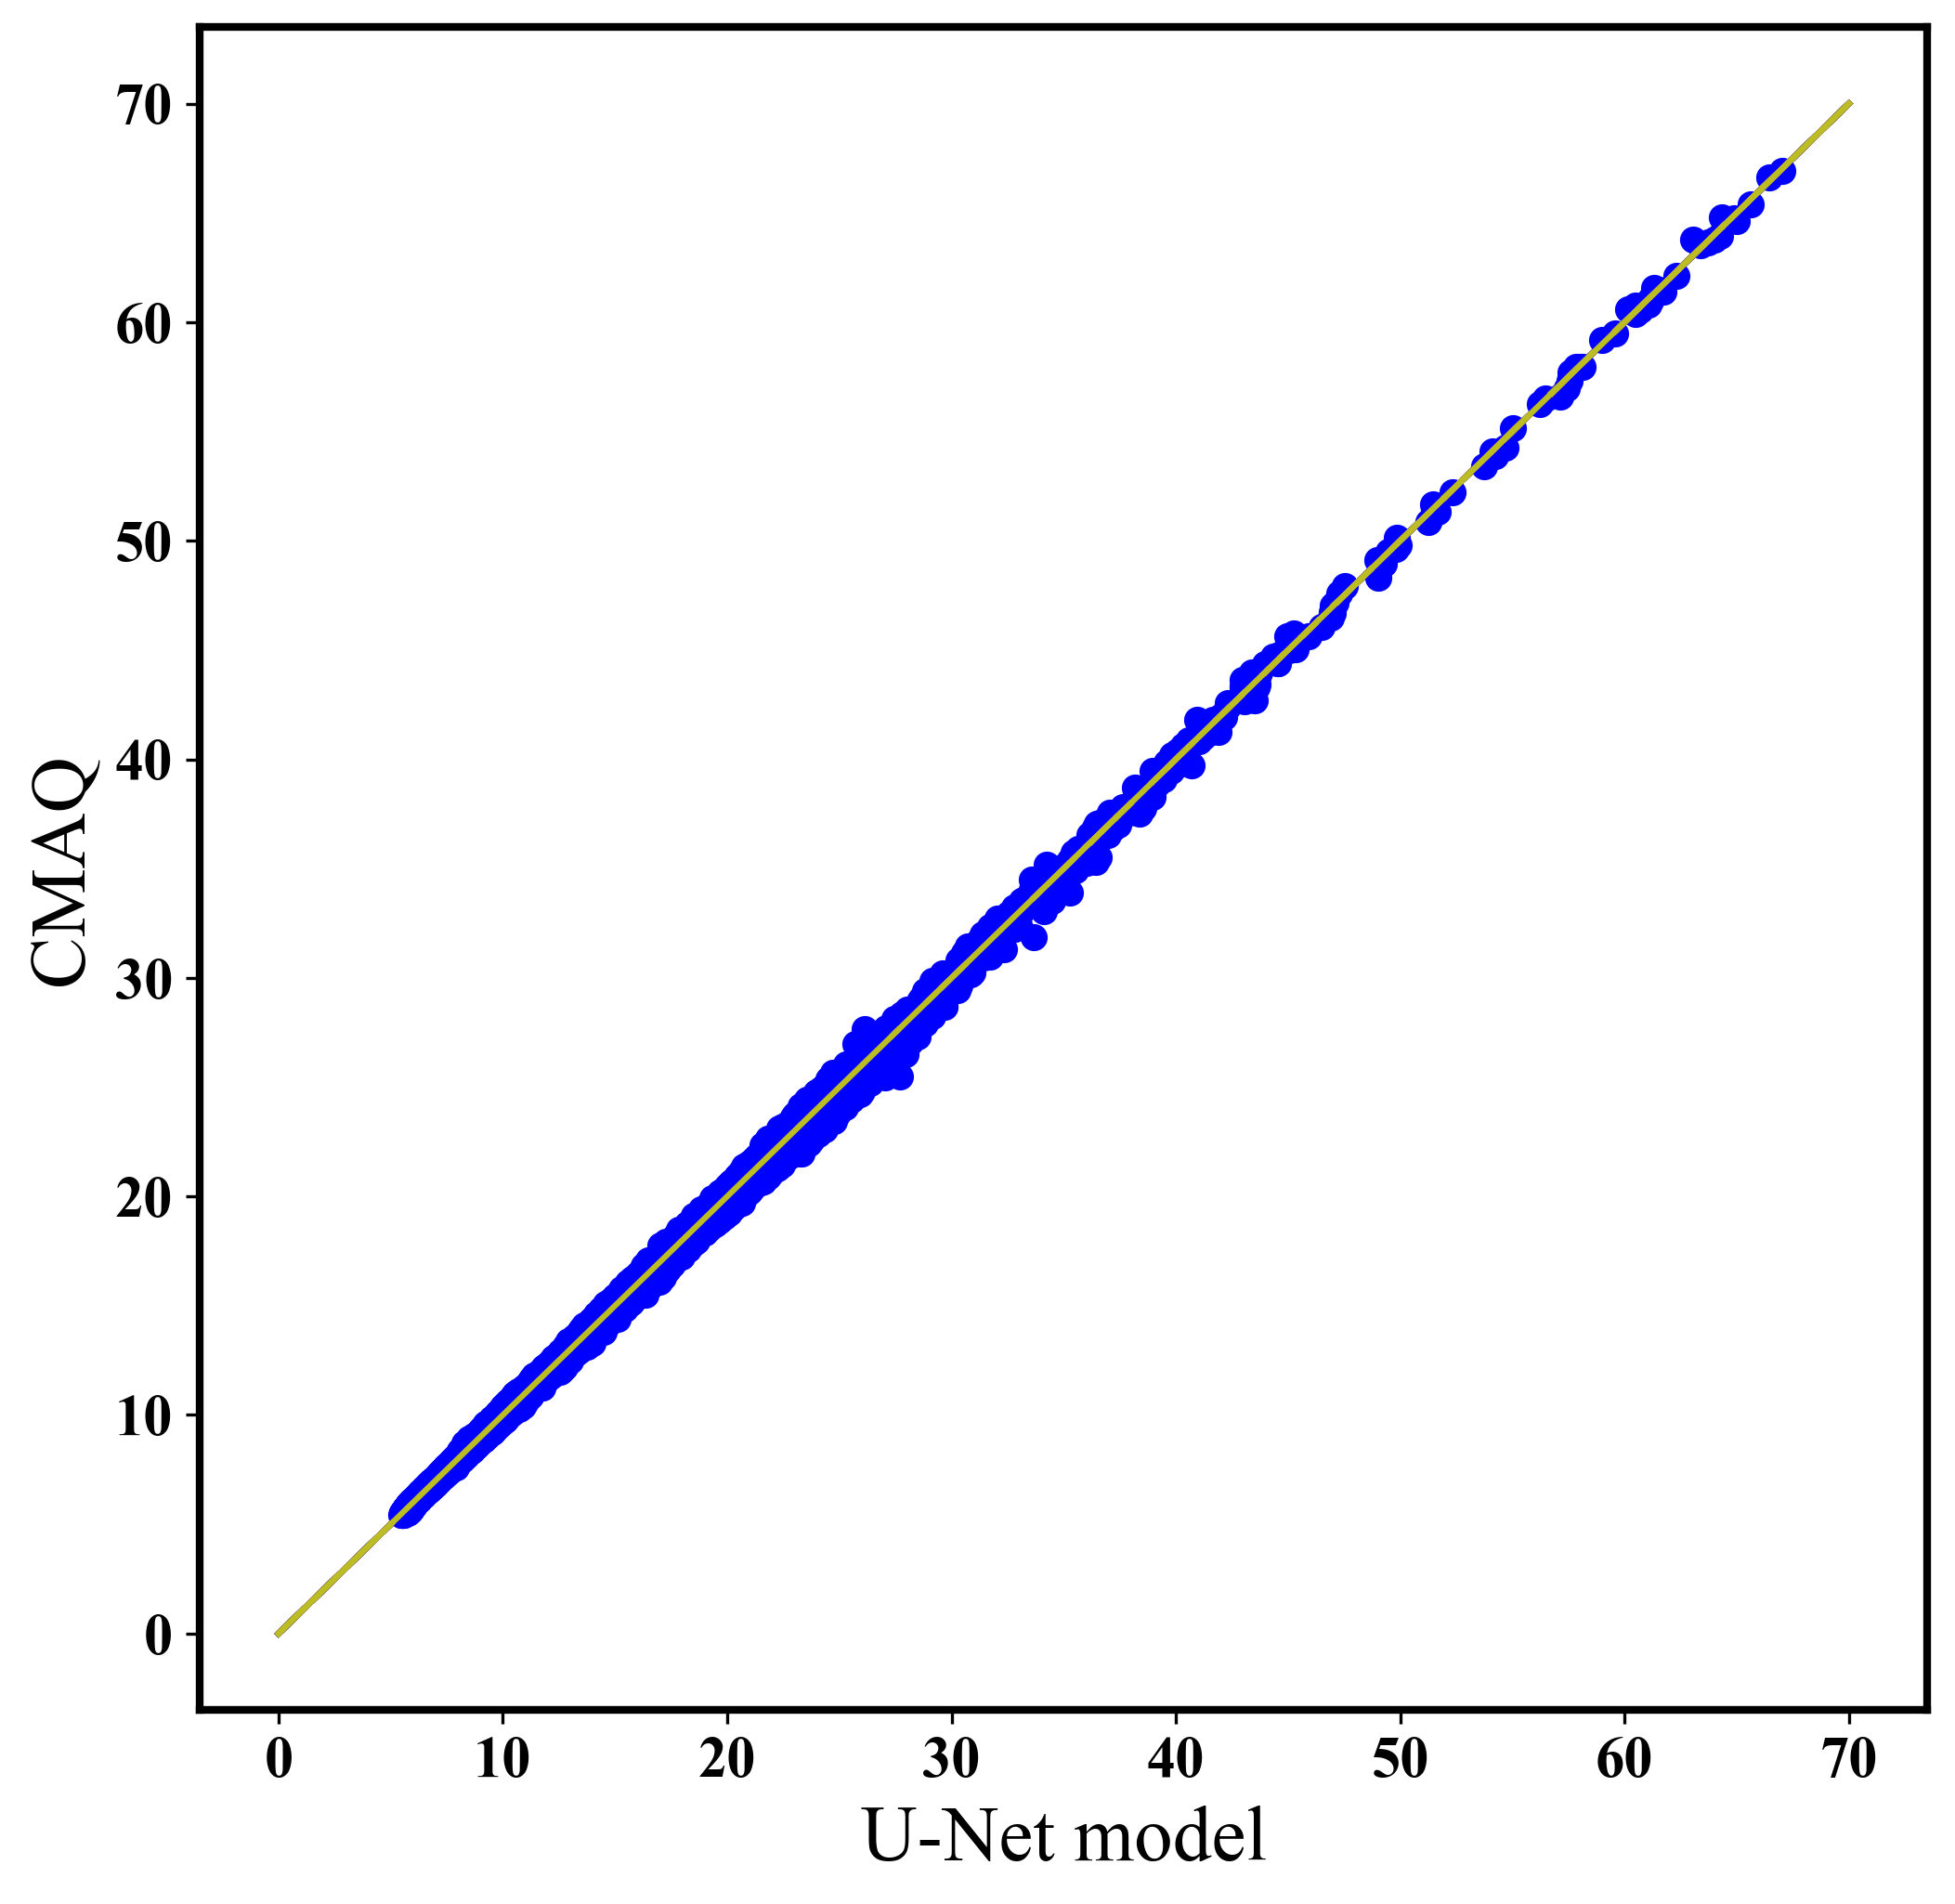

In [11]:
# In[] 테스트데이터 49개 포인트 전부
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
font = {'family' : 'times new roman', 
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
plt.rc('figure',facecolor = 'white')
title_font = {'fontname':'times new roman', 'size':'20', 'color':'black', 'weight':'normal',
  'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'times new roman', 'size':'20'}

plt.figure(figsize=(8,8), dpi = 300)


for j in range(49):
    # plt.figure(figsize=(12,10.5))
    plt.plot(pre[j][::-1].reshape(64*64), tt[j][::-1].reshape(64*64),'bo')
    plt.plot([0,70],[0,70])

plt.xlabel('U-Net model')
plt.ylabel('CMAQ')

<AxesSubplot:>

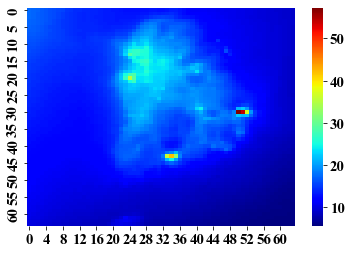

In [34]:
test = net(torch.FloatTensor(x_test).permute(0,3,1,2).to(device))[0]
test = test.cpu().detach().numpy().reshape(64,64)
plt.figure()
sns.heatmap(test[::-1], cmap = 'jet')

<AxesSubplot:>

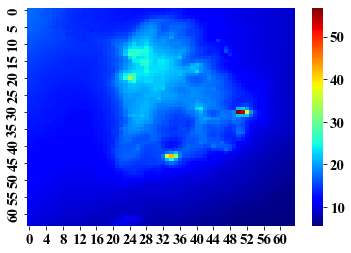

In [35]:
test2 = pm2_5[0]
test2 = test2.reshape(64,64)
plt.figure()
sns.heatmap(test2[::-1], cmap = 'jet')

In [94]:
# 1~49 시나리오 잔차, pred, true 이미지
for i in range(len(pm2_5)):
    fig = plt.figure()
    
    test = net(torch.FloatTensor(x_test).permute(0,3,1,2).to(device))[i]
    test = test.cpu().detach().numpy().reshape(64,64)

    test2 = pm2_5[i]
    test2 = test2.reshape(64,64)

    resid = test - test2
    
    # 잔차차트
    sns.heatmap(resid[::-1], cmap = 'jet', vmin=-2, vmax=2)
    plt.savefig(f"plots/resid/{i}_resid.png")
    plt.close()
    
    # 예측값차트
    fig = plt.figure()
    sns.heatmap(test[::-1], cmap = 'jet',vmin=0, vmax=80)
    plt.savefig(f"plots/pred/{i}_pred.png")
    plt.close()
    
    # cmaq 결과값차트
    fig = plt.figure()
    sns.heatmap(test2[::-1], cmap = 'jet',vmin=0, vmax=80)
    plt.savefig(f"plots/true/{i}_true.png")
    plt.close()
    
    # 비교차트
    fig = plt.figure(figsize = (10,30))
    
    ax1 = fig.add_subplot(3,1,1)
    sns.heatmap(resid[::-1], cmap = 'jet',vmin=-2, vmax=2,ax = ax1,)
    
    ax2 = fig.add_subplot(3,1,2)
    sns.heatmap(test[::-1], cmap = 'jet',vmin=0, vmax=80,ax = ax2,)
    
    ax3 = fig.add_subplot(3,1,3)
    sns.heatmap(test2[::-1], cmap = 'jet',vmin=0, vmax=80,ax = ax3,)
    
    plt.savefig(f"plots/compare/{i}_compare.png")
    plt.close()
    
print('clear')

clear


In [121]:
# 전체 시나리오 트레인 테슽별 인풋, target 비교
for i in range(len(y_train)):
    fig = plt.figure(figsize = (20,30))
    
    ax1 = fig.add_subplot(3,2,1)
    sns.heatmap(x_train[i,:,:,0][::-1], cmap = 'jet',ax = ax1,vmin=0, vmax=15) # vmin=-2, vmax=2
    
    ax2 = fig.add_subplot(3,2,2)
    sns.heatmap(x_train[i,:,:,1][::-1], cmap = 'jet',ax = ax2,vmin=0, vmax=8)
    
    ax3 = fig.add_subplot(3,2,3)
    sns.heatmap(x_train[i,:,:,2][::-1], cmap = 'jet',ax = ax3,vmin=0, vmax=11)
    
    ax4 = fig.add_subplot(3,2,4)
    sns.heatmap(x_train[i,:,:,3][::-1], cmap = 'jet',ax = ax4,vmin=0, vmax=4)
    
    ax4 = fig.add_subplot(3,2,5)
    sns.heatmap(y_train[i].reshape(64,64)[::-1], cmap = 'jet',ax = ax4,vmin=0, vmax=80)
    
    plt.savefig(f"plots/train_inputntarget/{i}_train_inputntarget.png")
    plt.close()
print('train_clear')

for i in range(len(pm2_5)):

    fig = plt.figure(figsize = (20,30))
    
    ax1 = fig.add_subplot(3,2,1)
    sns.heatmap(x_test[i,:,:,0][::-1], cmap = 'jet',ax = ax1,vmin=0, vmax=15) # vmin=-2, vmax=2
    
    ax2 = fig.add_subplot(3,2,2)
    sns.heatmap(x_test[i,:,:,1][::-1], cmap = 'jet',ax = ax2,vmin=0, vmax=8)
    
    ax3 = fig.add_subplot(3,2,3)
    sns.heatmap(x_test[i,:,:,2][::-1], cmap = 'jet',ax = ax3,vmin=0, vmax=11)
    
    ax4 = fig.add_subplot(3,2,4)
    sns.heatmap(x_test[i,:,:,3][::-1], cmap = 'jet',ax = ax4,vmin=0, vmax=4)
    
    ax4 = fig.add_subplot(3,2,5)
    sns.heatmap(pm2_5[i].reshape(64,64)[::-1], cmap = 'jet',ax = ax4,vmin=0, vmax=80)
    
    plt.savefig(f"plots/test_inputntarget/{i}_test_inputntarget.png")
    plt.close()
print('test_clear')
    

train_clear
test_clear


In [64]:
# 테스트셋 전체픽셀 값 저장
import pandas as pd

pd_test_values_by_pix = []
for i in range(len(pm2_5)):
    pd_test_values_by_pix.append(pd.DataFrame(pm2_5[i].reshape(-1)))

concated = pd.concat(pd_test_values_by_pix, axis = 1)
concated.to_csv('concated_label.csv')

In [42]:
# In[]
from torchsummary import summary

summary(net)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       2,368
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-4                       36,928
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
├─MaxPool2d: 1-3                         --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-7                       73,856
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
├─Sequential: 1-5                        --
|    └─Conv2d: 2-10                      147,584
|    └─BatchNorm2d: 2-11                 256
|    └─ReLU: 2-12                        --
├─MaxPool2d: 1-6                         --
├─Sequential: 1-7                        --
|    └─Conv2d: 2-13                      295,168
|    └─BatchNorm2d: 2-14                 512
|

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       2,368
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-4                       36,928
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
├─MaxPool2d: 1-3                         --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-7                       73,856
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
├─Sequential: 1-5                        --
|    └─Conv2d: 2-10                      147,584
|    └─BatchNorm2d: 2-11                 256
|    └─ReLU: 2-12                        --
├─MaxPool2d: 1-6                         --
├─Sequential: 1-7                        --
|    └─Conv2d: 2-13                      295,168
|    └─BatchNorm2d: 2-14                 512
|

In [61]:
# In[] r squared

def r_square(y_true, y_pred):
    SS_res = np.sum(np.square(y_true - y_pred))
    SS_tot = np.sum(np.square(y_true - np.mean(y_pred)))
    return (1-SS_res / SS_tot)
# In[]
def NME(y_true, y_pred):
    return np.sum( abs( (y_pred - y_true) / y_true ) ) / len(y_pred)
    

# In[] r sq
r_sq = []

for i in range(49):
    r_sq.append(r_square(pre[i][::-1].reshape(64*64), pm2_5[i][::-1].reshape(64*64)))

print(np.mean(r_sq),np.std(r_sq),np.min(r_sq))

0.9983457738280821 0.0006374506339076827 0.996150943155866


0.0011525470181181117

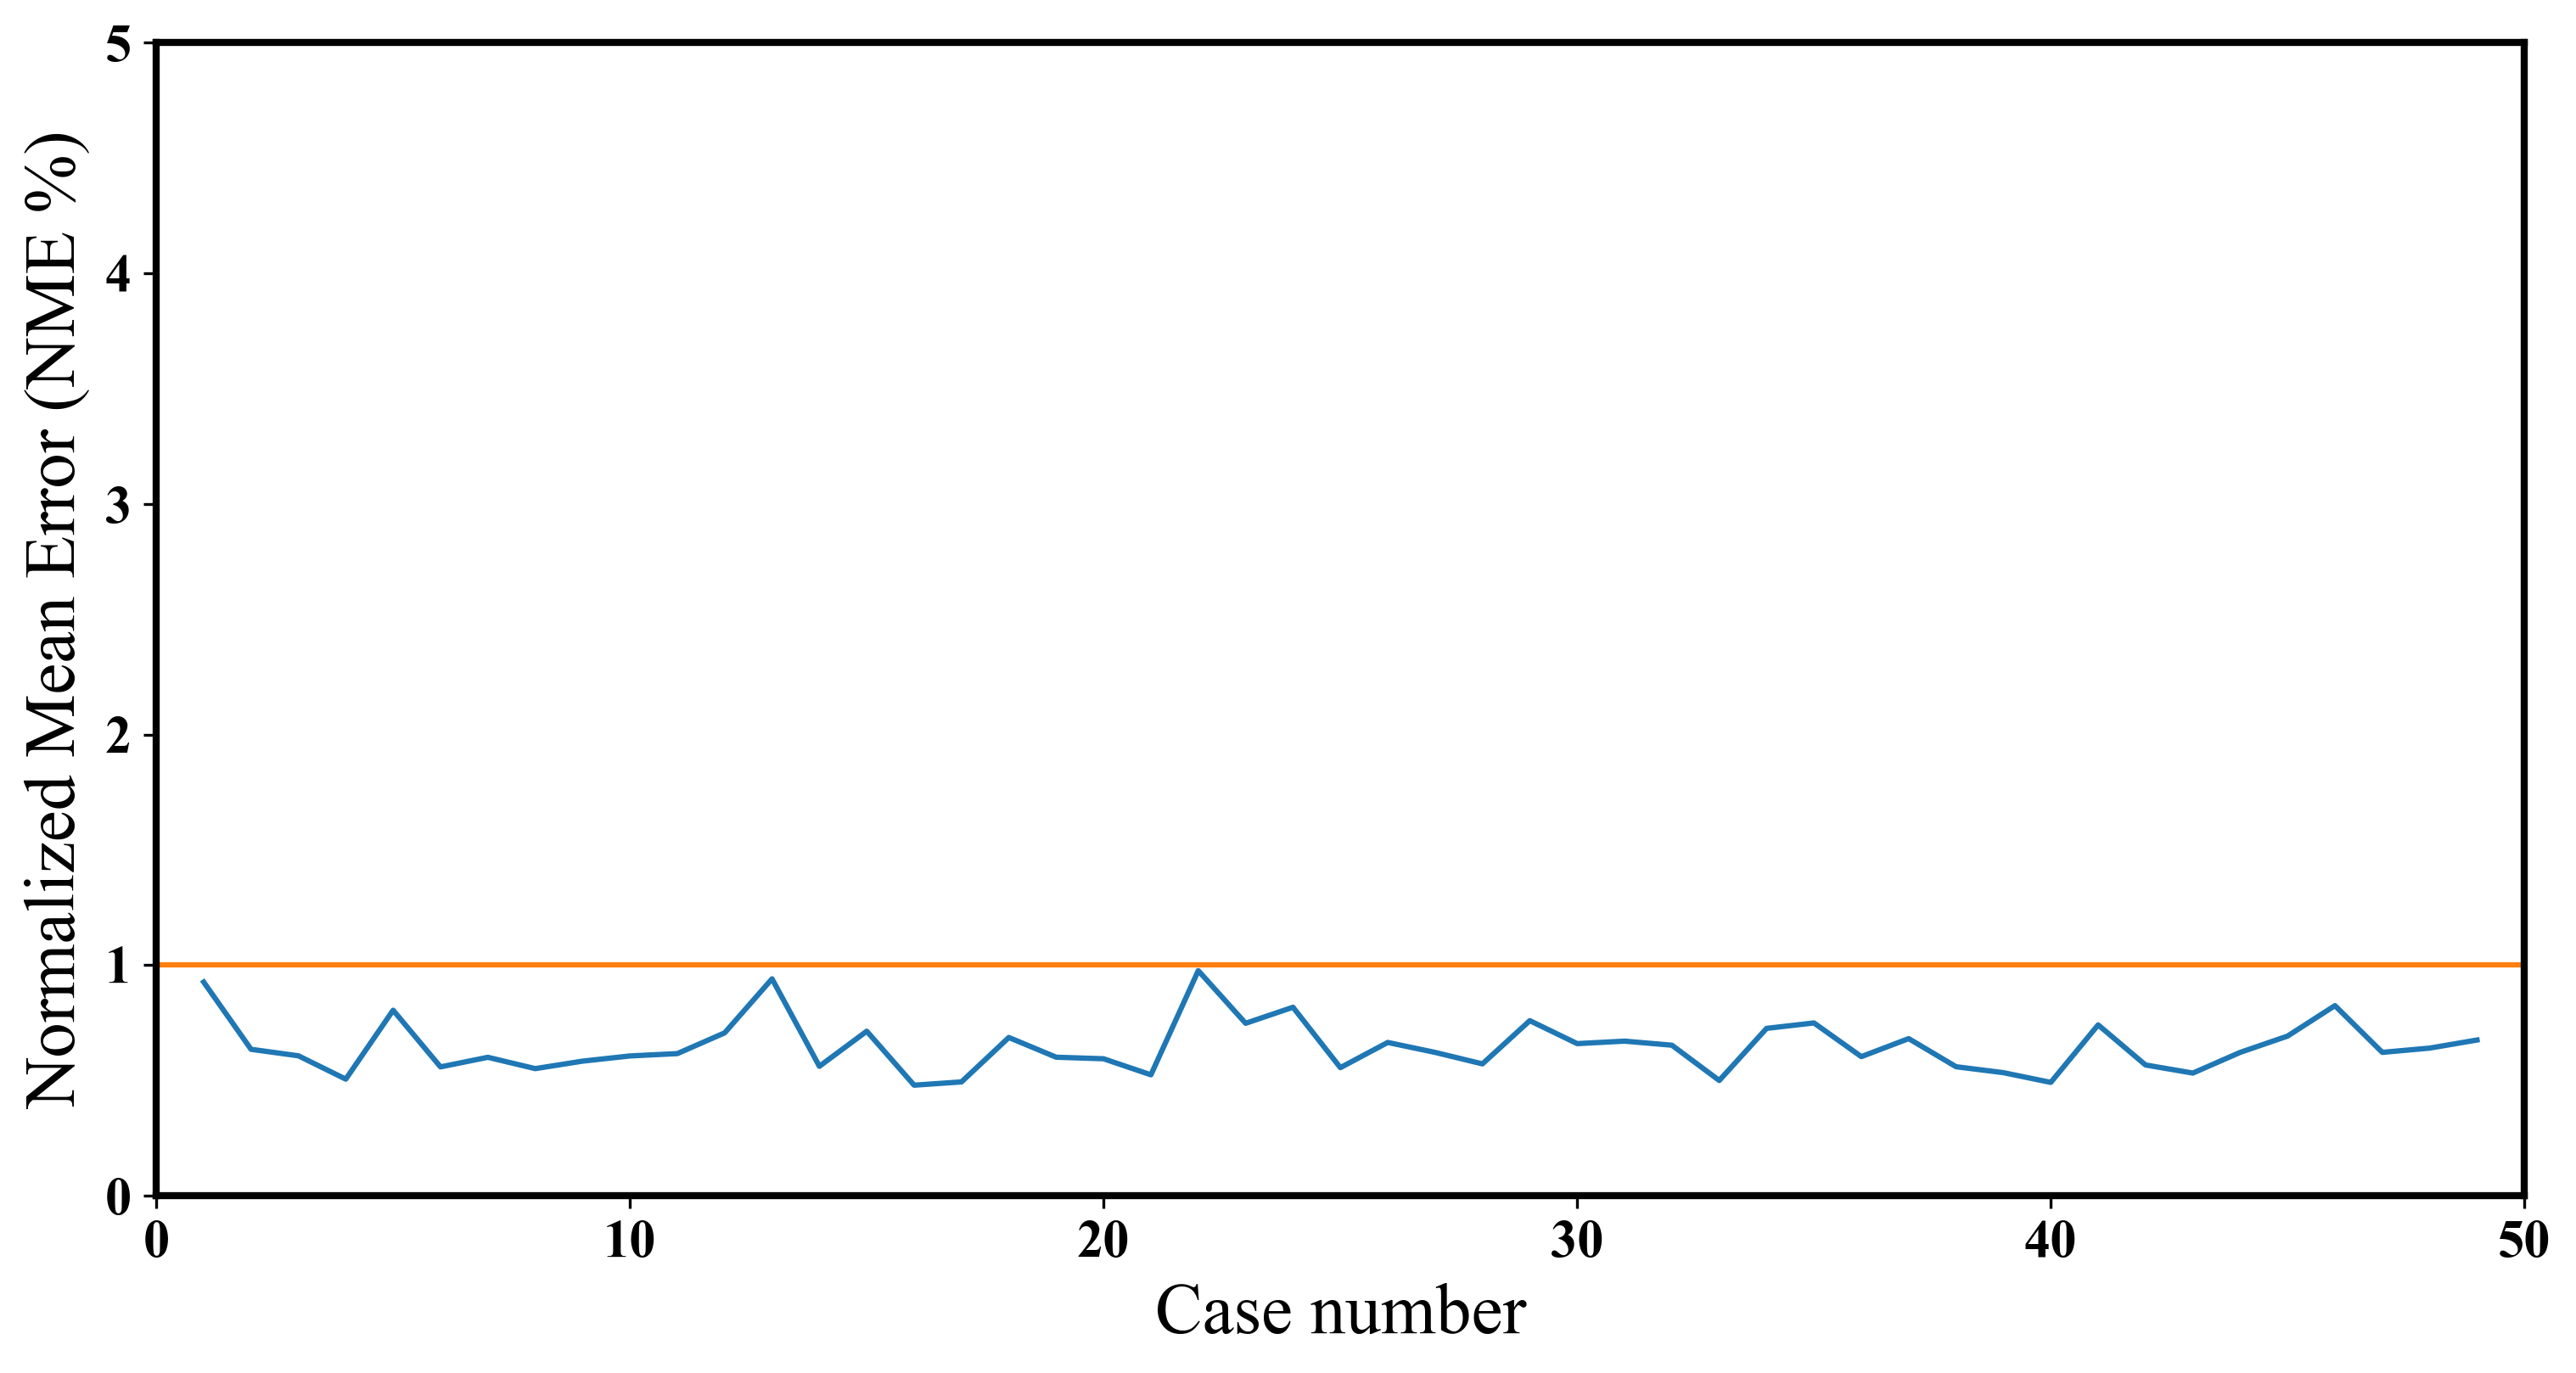

In [43]:
# In[]
result = []
                                                                                                                                                                                                                                                                                                                      
for i in range(49):
    result.append(NME(pre[i][::-1].reshape(64*64), pm2_5[i][::-1].reshape(64*64)))
    
# In[]
plt.figure(figsize=(12,6), dpi = 300)
plt.plot(np.arange(1,50,1), np.array(result) * 100)
plt.xlim([0,50])
plt.ylim([0,5])
plt.plot([0,50],[1,1])
plt.xlabel('Case number') ; plt.ylabel('Normalized Mean Error (NME %)')
# In[]
np.max(result)
np.mean(result)
np.std(result)